In [1]:
import sys
!{sys.executable} -m pip install pymongo
!{sys.executable} -m pip install pyyaml
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install isoweek
import os
print(os.getcwd())
# Get Mongo database
from yaml import load
from pymongo import MongoClient
from getsecret import getsecret

client = MongoClient(getsecret("MONGODB_URI"))
db = client[getsecret("DB_NAME")]
ext_client = MongoClient(getsecret("EXT_URI"))
ext_db = ext_client[getsecret("DB_NAME")]
# Get all synced accounts and their respective users.
import urllib.request as req
import json
accounts = json.loads(req.urlopen("http://localhost:5000/synced_emails").read().decode("utf-8"))

/Users/drewgregory/JupyterNotebooks/habitlab-data-analysis


In [2]:
# Now, for each day, get frequency intensity
INTENSITY = "intensity"
TOTAL_TIME = "total_time"
ANDROID = "android"
HASH = "email_hash"
GOALS = "goals"
FREQ_GOALS = "freq_goals"
INFREQ_GOALS = "infreq_goals"
OTHER_TIME = "other_time"
GOAL_TIME = "goal_time"
day_stats = []
import math
import moment
for account in accounts:
    curr_date = ""
    day_data = {INTENSITY: 0, INFREQ_GOALS: set([]),  TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), FREQ_GOALS: set([]), OTHER_TIME: 0 }
    for user in account[ANDROID]:
        for s in db[user+ "_sessions"].find({"enabled": {"$exists": True}, "duration": {"$lt": 86400}}):
            time = moment.unix(s["timestamp"])
            date = time.format("YYYY-MM-DD")
            if date != curr_date:
                if curr_date != "" and day_data[TOTAL_TIME] > 0 and len(day_data[GOALS]) > 0 and day_data[GOAL_TIME] > 0 and day_data[OTHER_TIME] > 0:
                    # Add obj and reset data
                    # take logs of time cuz time is log-norm distributed
                    for key in day_data:
                        if "time" in key:
                            day_data[key]= math.log(day_data[key])
                    day_data[INTENSITY] = len(day_data[FREQ_GOALS])/len(day_data[GOALS])
                    day_stats.append(day_data)
                    day_data = {INTENSITY: 0, INFREQ_GOALS: set([]), TOTAL_TIME: 0, GOAL_TIME: 0, HASH: account["_id"], GOALS: set([]), FREQ_GOALS: set([]), OTHER_TIME: 0 }
                curr_date = date
            if "enabled" in s:
                if s["enabled"]:
                    day_data[GOALS].add(s["domain"])
                    if s["duration"] > 0:
                        if s["domain"] + "_domain_time" not in day_data:
                            day_data[s["domain"]+"_domain_time"] = 0
                        day_data[s["domain"]+"_domain_time"] += s["duration"]
                    if "frequent" in s and s["frequent"]:
                        day_data[FREQ_GOALS].add(s["domain"])
                    elif "frequent" in s:
                        day_data[INFREQ_GOALS].add(s["domain"])
                    day_data[GOAL_TIME] += s["duration"]
                day_data[OTHER_TIME] += s["duration"]
            day_data[TOTAL_TIME] += (s["duration"])
            

In [3]:
import matplotlib.pyplot as pyplot
pyplot.figure(12)
pyplot.hist([math.exp(day[TOTAL_TIME]) for day in day_stats if math.exp(day[TOTAL_TIME]) < 86400], bins=50)

(array([183., 168., 178., 178., 201., 192., 199., 155., 144., 143., 131.,
        100., 124.,  95.,  78.,  79.,  62.,  69.,  46.,  50.,  33.,  59.,
         33.,  37.,  31.,  31.,  38.,  25.,  27.,  21.,  21.,  21.,  27.,
         11.,  14.,  14.,  21.,  13.,  12.,  12.,  11.,  20.,   8.,   7.,
         11.,  11.,  22.,  15.,  12.,  15.]),
 array([4.500000e+01, 1.771920e+03, 3.498840e+03, 5.225760e+03,
        6.952680e+03, 8.679600e+03, 1.040652e+04, 1.213344e+04,
        1.386036e+04, 1.558728e+04, 1.731420e+04, 1.904112e+04,
        2.076804e+04, 2.249496e+04, 2.422188e+04, 2.594880e+04,
        2.767572e+04, 2.940264e+04, 3.112956e+04, 3.285648e+04,
        3.458340e+04, 3.631032e+04, 3.803724e+04, 3.976416e+04,
        4.149108e+04, 4.321800e+04, 4.494492e+04, 4.667184e+04,
        4.839876e+04, 5.012568e+04, 5.185260e+04, 5.357952e+04,
        5.530644e+04, 5.703336e+04, 5.876028e+04, 6.048720e+04,
        6.221412e+04, 6.394104e+04, 6.566796e+04, 6.739488e+04,
        6.912180e+

In [4]:
import pandas as pd
data_frame_dict = { key: [] for key in day_stats[0] if "domain_time" not in key}
AVG_GOAL_TIME = "avg_goal_time"
data_frame_dict[AVG_GOAL_TIME] = []
# Let's also count up the freq to see if they're roughly equal
field_stats = {}
for item in day_stats:
    for key in item:
        if "domain_time" not in key:
            if key == INTENSITY:
                data_frame_dict[key].append(len(item[FREQ_GOALS]))
            else:
                data_frame_dict[key].append((item[key]))
    data_frame_dict[AVG_GOAL_TIME].append(item[GOAL_TIME]/len(item[GOALS]))
df = pd.DataFrame(data_frame_dict)
df.to_csv('effect_freq_time_spent.csv')

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R -i df -w 5 -h 5 --units in -r 200

#install.packages('ez')
#install.packages('lme4')

library(lme4)
library(sjPlot)
library(lmerTest)
#library(ez)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/r

In [7]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does total time spent per day on phone change depending on percentagre
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(total_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: total_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 9143.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9999 -0.4055  0.1242  0.5654  2.6522 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6211   0.7881  
 Residual               0.7776   0.8818  
Number of obs: 3227, groups:  email_hash, 494

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 8.948e+00  5.021e-02 7.758e+02  178.19   <2e-16 ***
intensity   1.837e-01  1.266e-02 3.103e+03   14.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.578


In [8]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(avg_goal_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: avg_goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 10219.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6318 -0.4388 -0.0764  0.3190  6.4287 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 1.283    1.133   
 Residual               1.029    1.015   
Number of obs: 3227, groups:  email_hash, 494

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    3.50671    0.06611  791.64052   53.04   <2e-16 ***
intensity     -0.39588    0.01506 3223.23335  -26.30   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.521


In [20]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone change depending on percentage
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(goal_time ~ intensity + (1|email_hash), data = df)
summary(results)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: goal_time ~ intensity + (1 | email_hash)
   Data: df

REML criterion at convergence: 10536.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2584 -0.4025  0.1305  0.5548  3.9424 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.7897   0.8887  
 Residual               1.2268   1.1076  
Number of obs: 3227, groups:  email_hash, 494

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 7.279e+00  5.940e-02 7.784e+02  122.55   <2e-16 ***
intensity   3.300e-01  1.561e-02 2.963e+03   21.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
intensity -0.603


f653fba473726066017d092faf775b60a39bd4616590332eb815f0bb74fa22f2


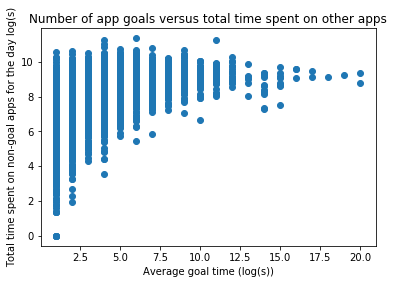

In [10]:
import matplotlib.pyplot as pyplot
import collections

most_active_users = {"": 0}
most_active_user = ""
for stat in day_stats:
    email = stat[HASH]
    if email not in most_active_users:
        most_active_users[email] = 0
    most_active_users[email] += 1
    if most_active_users[email] > most_active_users[most_active_user]:
        most_active_user = email
print(most_active_user)
pyplot.figure(43)
pyplot.title("Number of app goals versus total time spent on other apps")
pyplot.xlabel("Average goal time (log(s))")
pyplot.ylabel("Total time spent on non-goal apps for the day log(s)")
pyplot.scatter([len(stat[GOALS]) for stat in day_stats], [(stat[GOAL_TIME]) for stat in day_stats])


In [11]:
%%R -i df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
df$email_hash <- factor(df$email_hash,  ordered=FALSE)
results <- lmer(other_time ~ avg_goal_time + (1|email_hash), data = df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "infreq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "freq_goals". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'set'>'
  (name, str(e)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/r

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ avg_goal_time + (1 | email_hash)
   Data: df

REML criterion at convergence: 9342.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.0857 -0.3657  0.1503  0.5573  2.5815 

Random effects:
 Groups     Name        Variance Std.Dev.
 email_hash (Intercept) 0.6478   0.8049  
 Residual               0.8291   0.9106  
Number of obs: 3227, groups:  email_hash, 494

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      9.45003    0.05517  861.68912 171.295   <2e-16 ***
avg_goal_time   -0.03089    0.01378 2947.52462  -2.243    0.025 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
avg_goal_tm -0.650


In [14]:
# see average change for time spent in goals vs. outside of goal when freq setting changes
from statistics import mean, StatisticsError
goal_time_change_stats = []
other_time_change_stats = []
user_stats = {}
max_time = 0
for day in day_stats:
    email = day[HASH]
    if day[HASH] not in user_stats:
        user_stats[email] = {FREQ_GOALS: set([]), INFREQ_GOALS: set([])}
    user_stats[email][FREQ_GOALS] = user_stats[email][FREQ_GOALS].union(day[FREQ_GOALS])
    user_stats[email][INFREQ_GOALS] = user_stats[email][INFREQ_GOALS].union(day[INFREQ_GOALS])
    for domain_time in day:
        if "_domain_time" in domain_time:
            domain = domain_time[:-len("_domain_time")]
            if domain not in user_stats[email]:
                user_stats[email][domain] = {"frequent_goal": [], "infrequent_goal": [], "frequent_other": [], "infrequent_other": []}
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                if day[domain_time] > max_time:
                    max_time = day[domain_time]
                    print(max_time)
                user_stats[email][domain][freq + "_goal"].append(day[domain_time])
                user_stats[email][domain][freq+"_other"].append(day[TOTAL_TIME] - day[domain_time])
for user in user_stats:
    for domain in user_stats[user][FREQ_GOALS].intersection(user_stats[user][INFREQ_GOALS]):
        if 0 not in user_stats[user][domain]["frequent_goal"] and 0 not in user_stats[user][domain]["infrequent_goal"]:
            try:
                mean_freq_goal = mean(user_stats[user][domain]["frequent_goal"])
                # print("frequent" + str(user_stats[user][domain]["frequent_goal"]))
                # print("infrequent  " + str(user_stats[user][domain]["infrequent_goal"]))
                goal_change = mean_freq_goal - mean(user_stats[user][domain]["infrequent_goal"])
                other_change = mean(user_stats[user][domain]["frequent_other"]) - mean(user_stats[user][domain]["infrequent_other"])
                goal_time_change_stats.append(goal_change)
                other_time_change_stats.append(other_change)
            except StatisticsError:
                pass

4.3694478524670215
8.339739766019143
8.733594061863055
9.11679862756782
9.914625296946584
10.663124474364906
11.05668271897453
11.340082840810044


In [21]:
# our next data set: goal_time, freq, goal, and email_hash
goal_stats_dict = {"app": [], "email": [], "time": [], "other_time": [], "frequency": []}
for day in day_stats:
    for key in day:
        if "domain_time" in key:
            domain = key[:-len("_domain_time")]
            if not (domain in day[FREQ_GOALS] and domain in day[INFREQ_GOALS]) and (domain in day[FREQ_GOALS] or domain in day[INFREQ_GOALS]):
                freq = "frequent" if domain in day[FREQ_GOALS] else "infrequent"
                goal_stats_dict["app"].append(domain)
                goal_stats_dict["email"].append(day[HASH])
                goal_stats_dict["time"].append(day[key])
                goal_stats_dict["other_time"].append(day[GOAL_TIME] - day[key])
                goal_stats_dict["frequency"].append(freq)
goal_freq_df = pd.DataFrame(goal_stats_dict)

In [16]:
%%R -i goal_freq_df -w 5 -h 5 --units in -r 200
# Does non-goal time spent per day on phone inversely depend on goal-time?
goal_freq_df$email <- factor(goal_freq_df$email,  ordered=FALSE)
goal_freq_df$app <- factor(goal_freq_df$app, ordered=FALSE)
goal_freq_df$frequency <- factor(goal_freq_df$frequency, levels=c("infrequent", "frequent"))
results <- lmer(other_time ~ frequency + (1|email) + (1|app), data = goal_freq_df)
summary(results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: other_time ~ frequency + (1 | email) + (1 | app)
   Data: goal_freq_df

REML criterion at convergence: 52837.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9742 -0.6756 -0.1472  0.5289  4.8330 

Random effects:
 Groups   Name        Variance Std.Dev.
 app      (Intercept) 2.2786   1.5095  
 email    (Intercept) 0.3388   0.5821  
 Residual             2.3791   1.5424  
Number of obs: 13827, groups:  app, 612; email, 493

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       3.308e+00  8.053e-02 7.126e+02   41.08   <2e-16 ***
frequencyfrequent 6.717e-02  2.883e-02 1.371e+04    2.33   0.0198 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
frqncyfrqnt -0.175


651
0.5053763440860215
[-0.08313014046388413, 0.0697503612282453]


<BarContainer object of 2 artists>

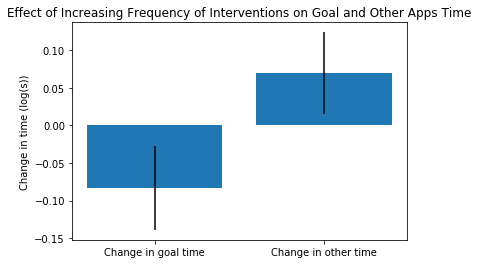

In [17]:
from scipy.stats import sem
pyplot.figure(32)
print(len(goal_time_change_stats))
pyplot.title("Effect of Increasing Frequency of Interventions on Goal and Other Apps Time")
pyplot.ylabel('Change in time (log(s))')
print(len([stat for stat in other_time_change_stats if stat > 0])/len(goal_time_change_stats))
print([mean(goal_time_change_stats), mean(other_time_change_stats)])
pyplot.bar(["Change in goal time", "Change in other time"], [mean(goal_time_change_stats), mean(other_time_change_stats)] , .8, yerr=[sem(goal_time_change_stats), sem(other_time_change_stats)])

In [ ]:
# Get freq stats
# week -> goal -> freq
# Top-level-domain-names that are not pertinent to the application.
TLDs = ['aaa', 'abb', 'abc', 'ac', 'aco', 'ad', 'ads', 'ae', 'aeg', 'af', 'afl', 'ag', 'ai', 'aig', 'al', 'am', 'anz', 'ao', 'aol', 'app', 'aq', 'ar', 'art', 'as', 'at', 'au', 'aw', 'aws', 'ax', 'axa', 'az', 'ba', 'bar', 'bb', 'bbc', 'bbt', 'bcg', 'bcn', 'bd', 'be', 'bet', 'bf', 'bg', 'bh', 'bi', 'bid', 'bio', 'biz', 'bj', 'bm', 'bms', 'bmw', 'bn', 'bnl', 'bo', 'bom', 'boo', 'bot', 'box', 'br', 'bs', 'bt', 'buy', 'bv', 'bw', 'by', 'bz', 'bzh', 'ca', 'cab', 'cal', 'cam', 'car', 'cat', 'cba', 'cbn', 'cbs', 'cc', 'cd', 'ceb', 'ceo', 'cf', 'cfa', 'cfd', 'cg', 'ch', 'ci', 'ck', 'cl', 'cm', 'cn', 'co', 'com', 'cr', 'crs', 'csc', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'dad', 'day', 'dds', 'de', 'dev', 'dhl', 'diy', 'dj', 'dk', 'dm', 'dnp', 'do', 'dog', 'dot', 'dtv', 'dvr', 'dz', 'eat', 'ec', 'eco', 'edu', 'ee', 'eg', 'er', 'es', 'esq', 'et', 'eu', 'eus', 'fan', 'fi', 'fit', 'fj', 'fk', 'fly', 'fm', 'fo', 'foo', 'fox', 'fr', 'frl', 'ftr', 'fun', 'fyi', 'ga', 'gal', 'gap', 'gb', 'gd', 'gdn', 'ge', 'gea', 'gf', 'gg', 'gh', 'gi', 'gl', 'gle', 'gm', 'gmo', 'gmx', 'gn', 'goo', 'gop', 'got', 'gov', 'gp', 'gq', 'gr', 'gs', 'gt', 'gu', 'gw', 'gy', 'hbo', 'hiv', 'hk', 'hkt', 'hm', 'hn', 'hot', 'how', 'hr', 'ht', 'hu', 'ibm', 'ice', 'icu', 'id', 'ie', 'ifm', 'il', 'im', 'in', 'inc', 'ing', 'ink', 'int', 'io', 'iq', 'ir', 'is', 'ist', 'it', 'itv', 'jcb', 'jcp', 'je', 'jio', 'jlc', 'jll', 'jm', 'jmp', 'jnj', 'jo', 'jot', 'joy', 'jp', 'ke', 'kfh', 'kg', 'kh', 'ki', 'kia', 'kim', 'km', 'kn', 'kp', 'kpn', 'kr', 'krd', 'kw', 'ky', 'kz', 'la', 'lat', 'law', 'lb', 'lc', 'lds', 'li', 'lk', 'llc', 'lol', 'lpl', 'lr', 'ls', 'lt', 'ltd', 'lu', 'lv', 'ly', 'ma', 'man', 'map', 'mba', 'mc', 'md', 'me', 'med', 'men', 'mg', 'mh', 'mil', 'mit', 'mk', 'ml', 'mlb', 'mls', 'mm', 'mma', 'mn', 'mo', 'moe', 'moi', 'mom', 'mov', 'mp', 'mq', 'mr', 'ms', 'msd', 'mt', 'mtn', 'mtr', 'mu', 'mv', 'mw', 'mx', 'my', 'mz', 'na', 'nab', 'nba', 'nc', 'ne', 'nec', 'net', 'new', 'nf', 'nfl', 'ng', 'ngo', 'nhk', 'ni', 'nl', 'no', 'now', 'np', 'nr', 'nra', 'nrw', 'ntt', 'nu', 'nyc', 'nz', 'obi', 'off', 'om', 'one', 'ong', 'onl', 'ooo', 'org', 'ott', 'ovh', 'pa', 'pay', 'pe', 'pet', 'pf', 'pg', 'ph', 'phd', 'pid', 'pin', 'pk', 'pl', 'pm', 'pn', 'pnc', 'pr', 'pro', 'pru', 'ps', 'pt', 'pub', 'pw', 'pwc', 'py', 'qa', 'qvc', 're', 'red', 'ren', 'ril', 'rio', 'rip', 'ro', 'rs', 'ru', 'run', 'rw', 'rwe', 'sa', 'sap', 'sas', 'sb', 'sbi', 'sbs', 'sc', 'sca', 'scb', 'sd', 'se', 'ses', 'sew', 'sex', 'sfr', 'sg', 'sh', 'si', 'sj', 'sk', 'ski', 'sky', 'sl', 'sm', 'sn', 'so', 'soy', 'sr', 'srl', 'srt', 'st', 'stc', 'su', 'sv', 'sx', 'sy', 'sz', 'tab', 'tax', 'tc', 'tci', 'td', 'tdk', 'tel', 'tf', 'tg', 'th', 'thd', 'tj', 'tjx', 'tk', 'tl', 'tm', 'tn', 'to', 'top', 'tr', 'trv', 'tt', 'tui', 'tv', 'tvs', 'tw', 'tz', 'ua', 'ubs', 'ug', 'uk', 'uno', 'uol', 'ups', 'us', 'uy', 'uz', 'va', 'vc', 've', 'vet', 'vg', 'vi', 'vig', 'vin', 'vip', 'vn', 'vu', 'wed', 'wf', 'win', 'wme', 'wow', 'ws', 'wtc', 'wtf', 'xin', 'xxx', 'xyz', 'ye', 'you', 'yt', 'yun', 'za', 'zip', 'zm', 'zw']
def get_name(name, device):
    """
    @param name: goal name (package name for Android)
    @param device: "android" or "browser" or "browser_domain"
    @return name of goal with subdomains removed and goal annotation removed (i.e. spend_less_time)
    """
    if device == ANDROID  and name =="com.google.android.gm" or device == BROWSER and "gmail" in name:
        return "gmail"
    name = name.lower()
    if "custom" in name and device == BROWSER:
        # strip off the "custom/spend_less_time_"
        name = name[SPEND_LESS_TIME_LENGTH:]
    elif device == BROWSER:
        return name.split('/spend')[0]
    # Now we have to get juicy part of domain.
    subs = list(filter(lambda x: x != "android" and x != "google" and x != "apps" and x not in TLDs, name.split('.')))
    if device == ANDROID: 
        if len(subs) > 0:
            return subs[0]
        return name
    else:
        if len(subs) > 0:
            return subs[len(subs) - 1]    
        
def get_freq_stats(user):
    stat = {}
    for setting in db[user + "_synced:goal_frequencies"].find({"val":{"algorithm": "isoweek_random"}}):
        stat[""]